# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

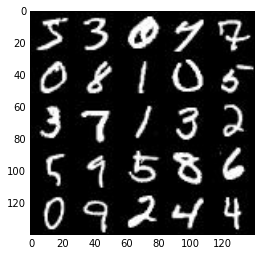

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

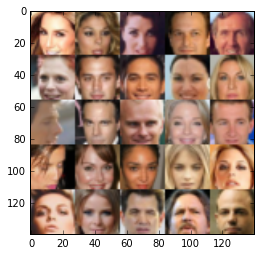

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # but I hear,  nchw have best performance!
#     image = tf.placeholder(tf.float32, shape=[None, image_channels, 
#                                               image_height, image_width])
    image = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)

    return image, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        initer = tf.truncated_normal_initializer(stddev=0.02)
        net = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                               kernel_initializer=initer)
        relu1 = tf.maximum(alpha * net, net)
        # 14x14x64
        
        net = tf.layers.conv2d(net, 128, 5, strides=2, padding='same',
                              kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(alpha * net, net)
        # 7x7x128
        
        net = tf.layers.conv2d(net, 256, 5, strides=2, padding='same',
                              kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(alpha * net, net)
        # 4x4x256

        net = tf.layers.conv2d(net, 512, 5, strides=2, padding='same',
                              kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(alpha * net, net)
        # 2x2x512
        
        # Flatten it
        net = tf.contrib.layers.flatten(net)
        logits = tf.layers.dense(net, 1, kernel_initializer=initer)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train) as scope:
        initer = tf.truncated_normal_initializer(stddev=0.02)
        # First fully connected layer
        net = tf.layers.dense(z, 7 * 7 * 128)
        # Reshape it to start the convolutional stack
        net = tf.reshape(net, (-1, 7, 7, 128))
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        # 7x7x512 now
        
        net = tf.layers.conv2d_transpose(net, 64, 5, strides=2, padding='same',
                                        kernel_initializer=initer)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        # 14x14x256 now
        
        # Output layer
        net = tf.layers.conv2d_transpose(net, out_channel_dim, 5, strides=2, 
                                            padding='same', kernel_initializer=initer)
        # 28x28x3 now

        out = tf.tanh(net)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = (data_image_mode == 'L') and 1 or 3
    image, z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(image, z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={image: batch_images, z: batch_z, lr: learning_rate})
                # run twice to make sure that the discriminator loss does not go to zero.
                _ = sess.run(g_train_opt, feed_dict={image: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={image: batch_images, z: batch_z, lr: learning_rate})

                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({image: batch_images, z: batch_z})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Epoch {}/{} {:.0f}%...".format(epoch_i+1, epochs, steps*batch_size/data_shape[0]*100), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, z, 
                                          out_channel_dim, data_image_mode)
                
        show_generator_output(sess, show_n_images, z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 2%... Discriminator Loss: 1.4327... Generator Loss: 0.5363
Epoch 1/2 4%... Discriminator Loss: 1.1804... Generator Loss: 1.2434
Epoch 1/2 6%... Discriminator Loss: 1.2688... Generator Loss: 0.7125
Epoch 1/2 9%... Discriminator Loss: 1.1106... Generator Loss: 1.3901
Epoch 1/2 11%... Discriminator Loss: 1.1332... Generator Loss: 1.1499


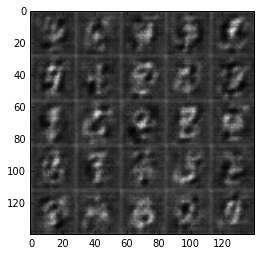

Epoch 1/2 13%... Discriminator Loss: 1.0150... Generator Loss: 1.1133
Epoch 1/2 15%... Discriminator Loss: 1.0659... Generator Loss: 1.0556
Epoch 1/2 17%... Discriminator Loss: 0.9584... Generator Loss: 0.9964
Epoch 1/2 19%... Discriminator Loss: 1.1236... Generator Loss: 0.7530
Epoch 1/2 21%... Discriminator Loss: 0.9401... Generator Loss: 1.0492


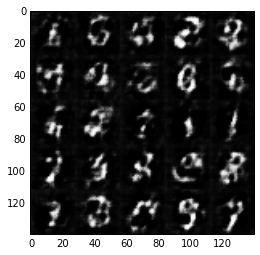

Epoch 1/2 23%... Discriminator Loss: 1.3407... Generator Loss: 0.5794
Epoch 1/2 26%... Discriminator Loss: 1.1448... Generator Loss: 0.7123
Epoch 1/2 28%... Discriminator Loss: 0.8890... Generator Loss: 1.9848
Epoch 1/2 30%... Discriminator Loss: 1.2324... Generator Loss: 0.8156
Epoch 1/2 32%... Discriminator Loss: 1.3927... Generator Loss: 0.5165


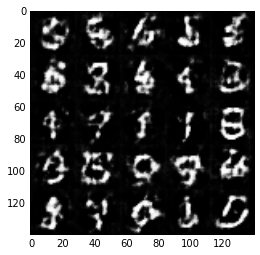

Epoch 1/2 34%... Discriminator Loss: 1.0971... Generator Loss: 1.2917
Epoch 1/2 36%... Discriminator Loss: 1.0008... Generator Loss: 1.1991
Epoch 1/2 38%... Discriminator Loss: 1.0732... Generator Loss: 1.0526
Epoch 1/2 41%... Discriminator Loss: 0.9101... Generator Loss: 1.1717
Epoch 1/2 43%... Discriminator Loss: 1.6388... Generator Loss: 0.3827


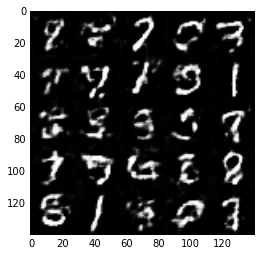

Epoch 1/2 45%... Discriminator Loss: 1.1678... Generator Loss: 0.6587
Epoch 1/2 47%... Discriminator Loss: 1.0547... Generator Loss: 0.9434
Epoch 1/2 49%... Discriminator Loss: 1.0984... Generator Loss: 1.0283
Epoch 1/2 51%... Discriminator Loss: 1.1036... Generator Loss: 0.7673
Epoch 1/2 53%... Discriminator Loss: 1.0098... Generator Loss: 0.9065


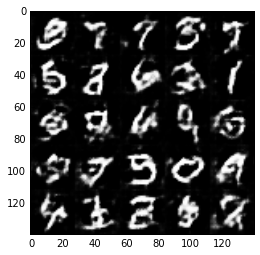

Epoch 1/2 55%... Discriminator Loss: 1.2849... Generator Loss: 0.6828
Epoch 1/2 58%... Discriminator Loss: 1.0268... Generator Loss: 0.8227
Epoch 1/2 60%... Discriminator Loss: 0.9751... Generator Loss: 1.1809
Epoch 1/2 62%... Discriminator Loss: 1.3951... Generator Loss: 0.5191
Epoch 1/2 64%... Discriminator Loss: 1.0957... Generator Loss: 1.4784


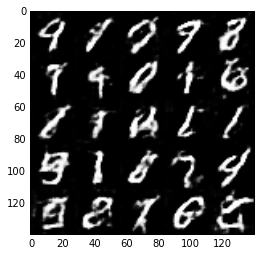

Epoch 1/2 66%... Discriminator Loss: 1.0741... Generator Loss: 1.0275
Epoch 1/2 68%... Discriminator Loss: 1.1065... Generator Loss: 0.8549
Epoch 1/2 70%... Discriminator Loss: 1.1674... Generator Loss: 0.7832
Epoch 1/2 73%... Discriminator Loss: 1.4395... Generator Loss: 0.5334
Epoch 1/2 75%... Discriminator Loss: 1.0384... Generator Loss: 0.8966


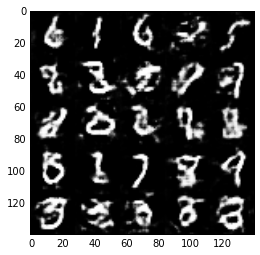

Epoch 1/2 77%... Discriminator Loss: 1.3107... Generator Loss: 0.5549
Epoch 1/2 79%... Discriminator Loss: 1.1189... Generator Loss: 0.8015
Epoch 1/2 81%... Discriminator Loss: 1.0557... Generator Loss: 0.7797
Epoch 1/2 83%... Discriminator Loss: 1.8411... Generator Loss: 0.3062
Epoch 1/2 85%... Discriminator Loss: 1.4716... Generator Loss: 0.4629


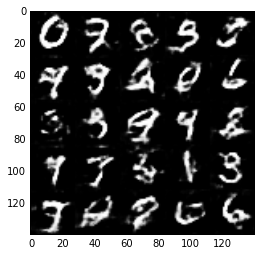

Epoch 1/2 87%... Discriminator Loss: 1.1761... Generator Loss: 0.6755
Epoch 1/2 90%... Discriminator Loss: 0.8054... Generator Loss: 1.2766
Epoch 1/2 92%... Discriminator Loss: 1.5449... Generator Loss: 0.5237
Epoch 1/2 94%... Discriminator Loss: 1.1471... Generator Loss: 0.7133
Epoch 1/2 96%... Discriminator Loss: 1.0257... Generator Loss: 0.9259


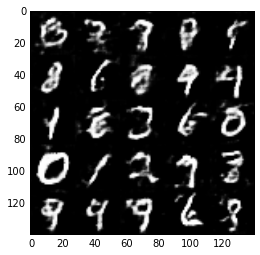

Epoch 1/2 98%... Discriminator Loss: 1.0566... Generator Loss: 1.2416
Epoch 2/2 2%... Discriminator Loss: 1.3416... Generator Loss: 0.5229
Epoch 2/2 4%... Discriminator Loss: 1.1105... Generator Loss: 1.0611
Epoch 2/2 6%... Discriminator Loss: 1.7400... Generator Loss: 0.3215
Epoch 2/2 9%... Discriminator Loss: 1.1319... Generator Loss: 1.5032
Epoch 2/2 11%... Discriminator Loss: 1.6052... Generator Loss: 0.3791


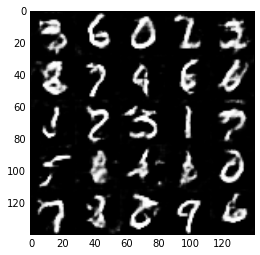

Epoch 2/2 13%... Discriminator Loss: 1.1704... Generator Loss: 0.7757
Epoch 2/2 15%... Discriminator Loss: 1.0909... Generator Loss: 0.9633
Epoch 2/2 17%... Discriminator Loss: 1.7919... Generator Loss: 0.3082
Epoch 2/2 19%... Discriminator Loss: 1.0869... Generator Loss: 0.7857
Epoch 2/2 21%... Discriminator Loss: 1.4218... Generator Loss: 0.5211


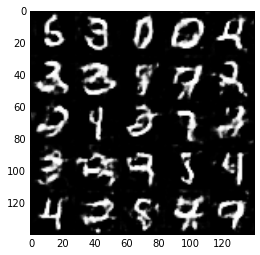

Epoch 2/2 23%... Discriminator Loss: 1.6990... Generator Loss: 0.3569
Epoch 2/2 26%... Discriminator Loss: 1.5807... Generator Loss: 0.3944
Epoch 2/2 28%... Discriminator Loss: 1.2455... Generator Loss: 0.6342
Epoch 2/2 30%... Discriminator Loss: 1.4721... Generator Loss: 0.4599
Epoch 2/2 32%... Discriminator Loss: 1.1192... Generator Loss: 0.7542


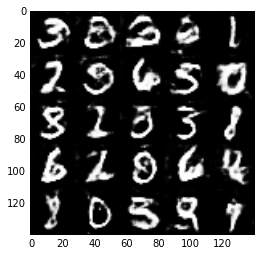

Epoch 2/2 34%... Discriminator Loss: 1.5993... Generator Loss: 2.9325
Epoch 2/2 36%... Discriminator Loss: 1.9801... Generator Loss: 0.3083
Epoch 2/2 38%... Discriminator Loss: 1.3501... Generator Loss: 0.5440
Epoch 2/2 41%... Discriminator Loss: 1.1152... Generator Loss: 0.7258
Epoch 2/2 43%... Discriminator Loss: 1.3501... Generator Loss: 0.5426


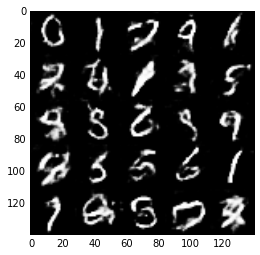

Epoch 2/2 45%... Discriminator Loss: 1.2177... Generator Loss: 0.6607
Epoch 2/2 47%... Discriminator Loss: 1.2026... Generator Loss: 0.6657
Epoch 2/2 49%... Discriminator Loss: 1.0132... Generator Loss: 1.5450
Epoch 2/2 51%... Discriminator Loss: 1.4245... Generator Loss: 0.4848
Epoch 2/2 53%... Discriminator Loss: 1.0117... Generator Loss: 0.8554


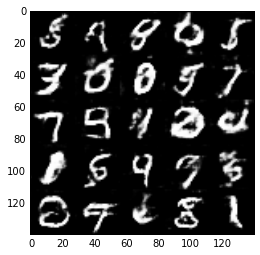

Epoch 2/2 55%... Discriminator Loss: 1.5927... Generator Loss: 0.4747
Epoch 2/2 58%... Discriminator Loss: 1.1398... Generator Loss: 0.7716
Epoch 2/2 60%... Discriminator Loss: 1.8440... Generator Loss: 0.3948
Epoch 2/2 62%... Discriminator Loss: 1.7986... Generator Loss: 0.3185
Epoch 2/2 64%... Discriminator Loss: 1.2069... Generator Loss: 0.6623


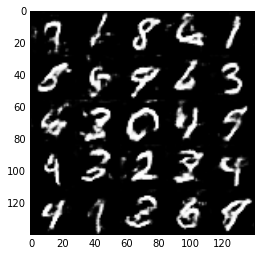

Epoch 2/2 66%... Discriminator Loss: 1.1547... Generator Loss: 0.7126
Epoch 2/2 68%... Discriminator Loss: 1.0918... Generator Loss: 0.7880
Epoch 2/2 70%... Discriminator Loss: 1.1857... Generator Loss: 0.6767
Epoch 2/2 73%... Discriminator Loss: 1.5550... Generator Loss: 0.4867
Epoch 2/2 75%... Discriminator Loss: 1.5489... Generator Loss: 0.4539


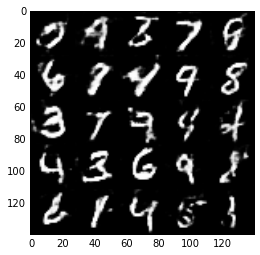

Epoch 2/2 77%... Discriminator Loss: 2.2267... Generator Loss: 0.2587
Epoch 2/2 79%... Discriminator Loss: 0.9438... Generator Loss: 0.8831
Epoch 2/2 81%... Discriminator Loss: 1.3241... Generator Loss: 0.5480
Epoch 2/2 83%... Discriminator Loss: 1.3582... Generator Loss: 0.5631
Epoch 2/2 85%... Discriminator Loss: 1.9729... Generator Loss: 0.3484


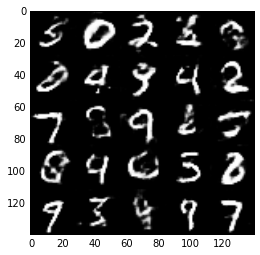

Epoch 2/2 87%... Discriminator Loss: 1.8488... Generator Loss: 0.3346
Epoch 2/2 90%... Discriminator Loss: 1.1096... Generator Loss: 0.7072
Epoch 2/2 92%... Discriminator Loss: 1.6835... Generator Loss: 0.6374
Epoch 2/2 94%... Discriminator Loss: 1.3764... Generator Loss: 0.5317
Epoch 2/2 96%... Discriminator Loss: 1.0894... Generator Loss: 0.8431


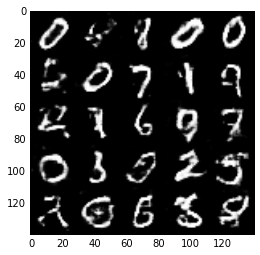

Epoch 2/2 98%... Discriminator Loss: 1.3489... Generator Loss: 0.5412


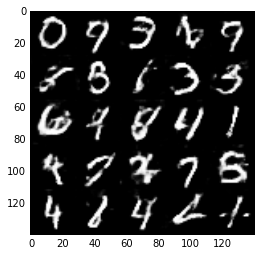

In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 1%... Discriminator Loss: 1.1826... Generator Loss: 1.5800
Epoch 1/1 1%... Discriminator Loss: 1.5001... Generator Loss: 1.3445
Epoch 1/1 2%... Discriminator Loss: 1.8000... Generator Loss: 0.3021
Epoch 1/1 3%... Discriminator Loss: 1.2151... Generator Loss: 1.2375
Epoch 1/1 3%... Discriminator Loss: 1.3467... Generator Loss: 0.5955


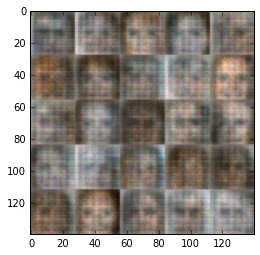

Epoch 1/1 4%... Discriminator Loss: 1.4182... Generator Loss: 1.1654
Epoch 1/1 4%... Discriminator Loss: 1.5968... Generator Loss: 0.5401
Epoch 1/1 5%... Discriminator Loss: 1.7196... Generator Loss: 0.3479
Epoch 1/1 6%... Discriminator Loss: 1.3452... Generator Loss: 0.8183
Epoch 1/1 6%... Discriminator Loss: 1.6338... Generator Loss: 0.6720


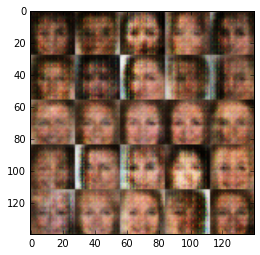

Epoch 1/1 7%... Discriminator Loss: 1.3757... Generator Loss: 0.7832
Epoch 1/1 8%... Discriminator Loss: 1.5490... Generator Loss: 0.6559
Epoch 1/1 8%... Discriminator Loss: 1.3603... Generator Loss: 0.7624
Epoch 1/1 9%... Discriminator Loss: 1.2893... Generator Loss: 0.7906
Epoch 1/1 9%... Discriminator Loss: 1.4154... Generator Loss: 0.7069


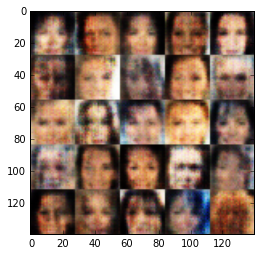

Epoch 1/1 10%... Discriminator Loss: 1.3300... Generator Loss: 0.9933
Epoch 1/1 11%... Discriminator Loss: 1.4866... Generator Loss: 0.5114
Epoch 1/1 11%... Discriminator Loss: 1.3753... Generator Loss: 0.7170
Epoch 1/1 12%... Discriminator Loss: 1.3036... Generator Loss: 0.7925
Epoch 1/1 13%... Discriminator Loss: 1.3301... Generator Loss: 0.7160


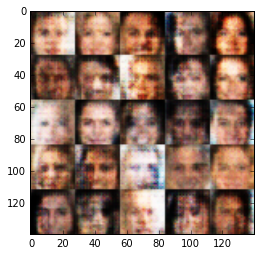

Epoch 1/1 13%... Discriminator Loss: 1.4605... Generator Loss: 0.6042
Epoch 1/1 14%... Discriminator Loss: 1.4495... Generator Loss: 0.6883
Epoch 1/1 15%... Discriminator Loss: 1.4667... Generator Loss: 0.7202
Epoch 1/1 15%... Discriminator Loss: 1.3793... Generator Loss: 0.7063
Epoch 1/1 16%... Discriminator Loss: 1.5014... Generator Loss: 0.6594


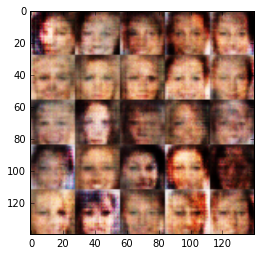

Epoch 1/1 16%... Discriminator Loss: 1.3153... Generator Loss: 0.8312
Epoch 1/1 17%... Discriminator Loss: 1.3044... Generator Loss: 0.6943
Epoch 1/1 18%... Discriminator Loss: 1.4538... Generator Loss: 0.5645
Epoch 1/1 18%... Discriminator Loss: 1.4061... Generator Loss: 0.6918
Epoch 1/1 19%... Discriminator Loss: 1.3057... Generator Loss: 0.7530


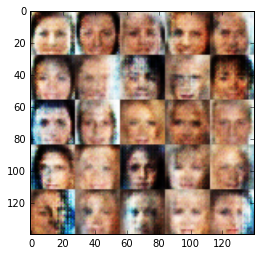

Epoch 1/1 20%... Discriminator Loss: 1.4095... Generator Loss: 0.7051
Epoch 1/1 20%... Discriminator Loss: 1.3919... Generator Loss: 0.5798
Epoch 1/1 21%... Discriminator Loss: 1.2805... Generator Loss: 0.8734
Epoch 1/1 21%... Discriminator Loss: 1.4983... Generator Loss: 0.6548
Epoch 1/1 22%... Discriminator Loss: 1.3594... Generator Loss: 0.7052


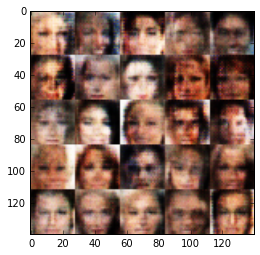

Epoch 1/1 23%... Discriminator Loss: 1.3187... Generator Loss: 0.7567
Epoch 1/1 23%... Discriminator Loss: 1.2377... Generator Loss: 0.9176
Epoch 1/1 24%... Discriminator Loss: 1.3329... Generator Loss: 0.7807
Epoch 1/1 25%... Discriminator Loss: 1.4755... Generator Loss: 0.6742
Epoch 1/1 25%... Discriminator Loss: 1.4841... Generator Loss: 0.5895


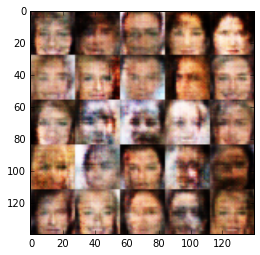

Epoch 1/1 26%... Discriminator Loss: 1.3253... Generator Loss: 0.8137
Epoch 1/1 27%... Discriminator Loss: 1.3594... Generator Loss: 0.7195
Epoch 1/1 27%... Discriminator Loss: 1.3193... Generator Loss: 0.8442
Epoch 1/1 28%... Discriminator Loss: 1.4225... Generator Loss: 0.6738
Epoch 1/1 28%... Discriminator Loss: 1.3167... Generator Loss: 0.7054


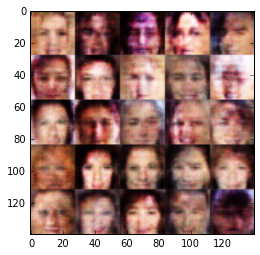

Epoch 1/1 29%... Discriminator Loss: 1.4368... Generator Loss: 0.5929
Epoch 1/1 30%... Discriminator Loss: 1.4583... Generator Loss: 0.6170
Epoch 1/1 30%... Discriminator Loss: 1.3566... Generator Loss: 0.7832
Epoch 1/1 31%... Discriminator Loss: 1.3217... Generator Loss: 0.6463
Epoch 1/1 32%... Discriminator Loss: 1.4196... Generator Loss: 0.5950


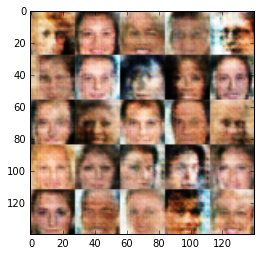

Epoch 1/1 32%... Discriminator Loss: 1.4154... Generator Loss: 0.6807
Epoch 1/1 33%... Discriminator Loss: 1.4472... Generator Loss: 0.6530
Epoch 1/1 33%... Discriminator Loss: 1.4063... Generator Loss: 0.6481
Epoch 1/1 34%... Discriminator Loss: 1.3704... Generator Loss: 0.6257
Epoch 1/1 35%... Discriminator Loss: 1.5276... Generator Loss: 0.4843


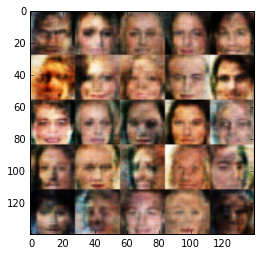

Epoch 1/1 35%... Discriminator Loss: 1.4081... Generator Loss: 0.5672
Epoch 1/1 36%... Discriminator Loss: 1.4738... Generator Loss: 0.6118
Epoch 1/1 37%... Discriminator Loss: 1.3670... Generator Loss: 0.7417
Epoch 1/1 37%... Discriminator Loss: 1.3081... Generator Loss: 0.6637
Epoch 1/1 38%... Discriminator Loss: 1.3102... Generator Loss: 0.7174


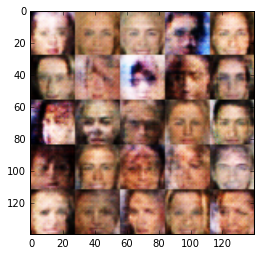

Epoch 1/1 39%... Discriminator Loss: 1.3451... Generator Loss: 0.6328
Epoch 1/1 39%... Discriminator Loss: 1.4076... Generator Loss: 0.5299
Epoch 1/1 40%... Discriminator Loss: 1.4859... Generator Loss: 0.7290
Epoch 1/1 40%... Discriminator Loss: 1.4032... Generator Loss: 0.5661
Epoch 1/1 41%... Discriminator Loss: 1.3417... Generator Loss: 0.7756


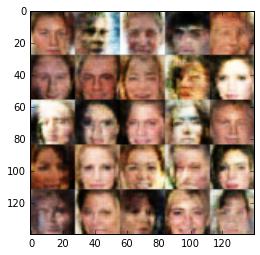

Epoch 1/1 42%... Discriminator Loss: 1.3234... Generator Loss: 0.7075
Epoch 1/1 42%... Discriminator Loss: 1.3462... Generator Loss: 0.6077
Epoch 1/1 43%... Discriminator Loss: 1.3941... Generator Loss: 0.8543
Epoch 1/1 44%... Discriminator Loss: 1.4226... Generator Loss: 0.6117
Epoch 1/1 44%... Discriminator Loss: 1.4037... Generator Loss: 0.6101


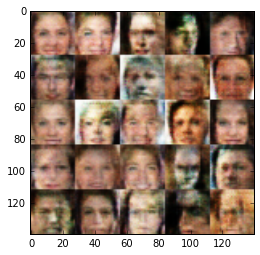

Epoch 1/1 45%... Discriminator Loss: 1.4391... Generator Loss: 0.6645
Epoch 1/1 45%... Discriminator Loss: 1.3783... Generator Loss: 0.5454
Epoch 1/1 46%... Discriminator Loss: 1.4616... Generator Loss: 0.9701
Epoch 1/1 47%... Discriminator Loss: 1.3218... Generator Loss: 0.7240
Epoch 1/1 47%... Discriminator Loss: 1.2871... Generator Loss: 0.9193


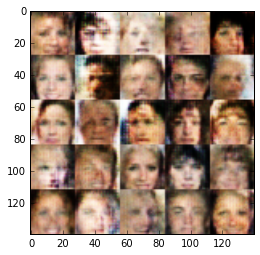

Epoch 1/1 48%... Discriminator Loss: 1.4320... Generator Loss: 0.5214
Epoch 1/1 49%... Discriminator Loss: 1.3843... Generator Loss: 0.5855
Epoch 1/1 49%... Discriminator Loss: 1.5108... Generator Loss: 0.4624
Epoch 1/1 50%... Discriminator Loss: 1.3603... Generator Loss: 0.9170
Epoch 1/1 51%... Discriminator Loss: 1.3388... Generator Loss: 0.6835


Epoch 1/1 51%... Discriminator Loss: 1.3021... Generator Loss: 0.6263
Epoch 1/1 52%... Discriminator Loss: 1.4181... Generator Loss: 0.5995
Epoch 1/1 52%... Discriminator Loss: 1.6179... Generator Loss: 0.4443
Epoch 1/1 53%... Discriminator Loss: 1.4538... Generator Loss: 0.6104
Epoch 1/1 54%... Discriminator Loss: 1.3318... Generator Loss: 0.7143


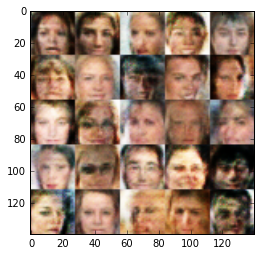

Epoch 1/1 54%... Discriminator Loss: 1.4097... Generator Loss: 0.6901
Epoch 1/1 55%... Discriminator Loss: 1.3474... Generator Loss: 0.5841
Epoch 1/1 56%... Discriminator Loss: 1.3709... Generator Loss: 0.6382
Epoch 1/1 56%... Discriminator Loss: 1.4047... Generator Loss: 0.6118
Epoch 1/1 57%... Discriminator Loss: 1.5061... Generator Loss: 0.4240


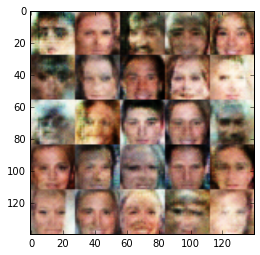

Epoch 1/1 57%... Discriminator Loss: 1.3226... Generator Loss: 0.6127
Epoch 1/1 58%... Discriminator Loss: 1.3500... Generator Loss: 0.6885
Epoch 1/1 59%... Discriminator Loss: 1.4506... Generator Loss: 0.5348
Epoch 1/1 59%... Discriminator Loss: 1.4469... Generator Loss: 0.7134
Epoch 1/1 60%... Discriminator Loss: 1.5075... Generator Loss: 0.5163


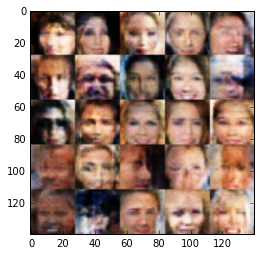

Epoch 1/1 61%... Discriminator Loss: 1.3368... Generator Loss: 0.6409
Epoch 1/1 61%... Discriminator Loss: 1.3790... Generator Loss: 0.6089
Epoch 1/1 62%... Discriminator Loss: 1.3693... Generator Loss: 0.8090
Epoch 1/1 63%... Discriminator Loss: 1.3959... Generator Loss: 0.5959
Epoch 1/1 63%... Discriminator Loss: 1.3136... Generator Loss: 0.6749


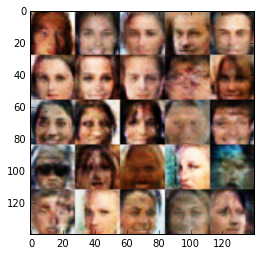

Epoch 1/1 64%... Discriminator Loss: 1.5047... Generator Loss: 0.5548
Epoch 1/1 64%... Discriminator Loss: 1.4880... Generator Loss: 0.4622
Epoch 1/1 65%... Discriminator Loss: 1.5611... Generator Loss: 0.3926
Epoch 1/1 66%... Discriminator Loss: 1.3405... Generator Loss: 0.7368
Epoch 1/1 66%... Discriminator Loss: 1.6362... Generator Loss: 0.3881


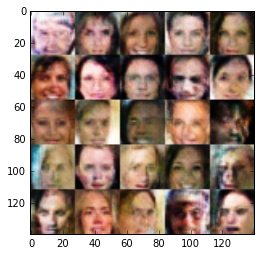

Epoch 1/1 67%... Discriminator Loss: 1.3243... Generator Loss: 0.5945
Epoch 1/1 68%... Discriminator Loss: 1.3798... Generator Loss: 0.6836
Epoch 1/1 68%... Discriminator Loss: 1.3374... Generator Loss: 0.6432
Epoch 1/1 69%... Discriminator Loss: 1.3157... Generator Loss: 0.6153
Epoch 1/1 69%... Discriminator Loss: 1.4064... Generator Loss: 0.5215


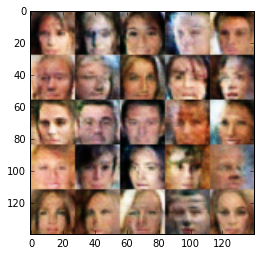

Epoch 1/1 70%... Discriminator Loss: 1.3917... Generator Loss: 0.5709
Epoch 1/1 71%... Discriminator Loss: 1.4755... Generator Loss: 0.4920
Epoch 1/1 71%... Discriminator Loss: 1.3485... Generator Loss: 0.5577
Epoch 1/1 72%... Discriminator Loss: 1.3223... Generator Loss: 1.0604
Epoch 1/1 73%... Discriminator Loss: 1.2119... Generator Loss: 0.9066


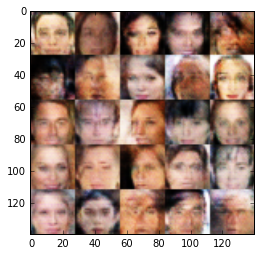

Epoch 1/1 73%... Discriminator Loss: 1.3143... Generator Loss: 0.5460
Epoch 1/1 74%... Discriminator Loss: 1.4583... Generator Loss: 0.4881
Epoch 1/1 75%... Discriminator Loss: 1.3085... Generator Loss: 0.7581
Epoch 1/1 75%... Discriminator Loss: 1.3362... Generator Loss: 0.7850
Epoch 1/1 76%... Discriminator Loss: 1.4532... Generator Loss: 0.4777


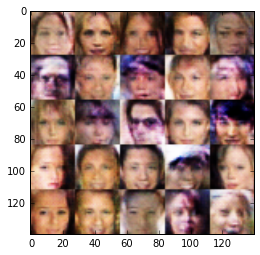

Epoch 1/1 76%... Discriminator Loss: 1.6557... Generator Loss: 0.3726
Epoch 1/1 77%... Discriminator Loss: 1.5680... Generator Loss: 0.4205
Epoch 1/1 78%... Discriminator Loss: 1.6384... Generator Loss: 0.3754
Epoch 1/1 78%... Discriminator Loss: 1.2694... Generator Loss: 0.7217
Epoch 1/1 79%... Discriminator Loss: 1.4243... Generator Loss: 0.7747


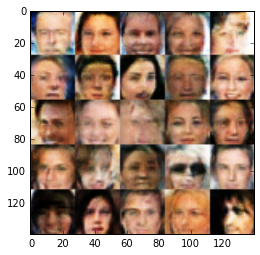

Epoch 1/1 80%... Discriminator Loss: 1.2650... Generator Loss: 0.9433
Epoch 1/1 80%... Discriminator Loss: 1.1797... Generator Loss: 0.7220
Epoch 1/1 81%... Discriminator Loss: 1.2604... Generator Loss: 0.6547
Epoch 1/1 82%... Discriminator Loss: 1.3522... Generator Loss: 0.6756
Epoch 1/1 82%... Discriminator Loss: 1.3264... Generator Loss: 0.6759


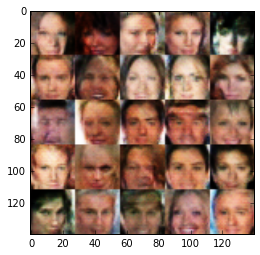

Epoch 1/1 83%... Discriminator Loss: 1.5443... Generator Loss: 0.5290
Epoch 1/1 83%... Discriminator Loss: 1.4236... Generator Loss: 0.5546
Epoch 1/1 84%... Discriminator Loss: 1.3305... Generator Loss: 0.9874
Epoch 1/1 85%... Discriminator Loss: 1.3249... Generator Loss: 0.6393
Epoch 1/1 85%... Discriminator Loss: 1.4188... Generator Loss: 0.5006


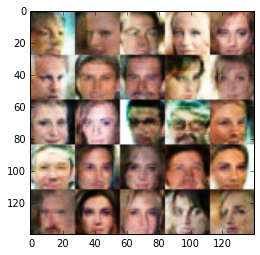

Epoch 1/1 86%... Discriminator Loss: 1.6270... Generator Loss: 0.4259
Epoch 1/1 87%... Discriminator Loss: 1.1926... Generator Loss: 0.6707
Epoch 1/1 87%... Discriminator Loss: 1.4792... Generator Loss: 1.1995
Epoch 1/1 88%... Discriminator Loss: 1.4258... Generator Loss: 0.5120
Epoch 1/1 88%... Discriminator Loss: 1.4076... Generator Loss: 0.5817


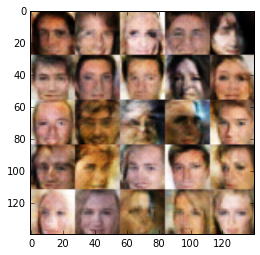

Epoch 1/1 89%... Discriminator Loss: 1.3186... Generator Loss: 0.6506
Epoch 1/1 90%... Discriminator Loss: 1.4617... Generator Loss: 0.4617
Epoch 1/1 90%... Discriminator Loss: 1.2072... Generator Loss: 0.7821
Epoch 1/1 91%... Discriminator Loss: 1.3024... Generator Loss: 0.5827
Epoch 1/1 92%... Discriminator Loss: 1.5164... Generator Loss: 0.4758


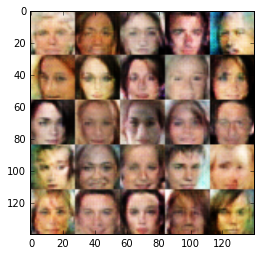

Epoch 1/1 92%... Discriminator Loss: 1.1911... Generator Loss: 0.7385
Epoch 1/1 93%... Discriminator Loss: 1.4023... Generator Loss: 0.8502
Epoch 1/1 94%... Discriminator Loss: 1.1858... Generator Loss: 0.8621
Epoch 1/1 94%... Discriminator Loss: 1.3024... Generator Loss: 0.6160
Epoch 1/1 95%... Discriminator Loss: 1.4124... Generator Loss: 0.5024


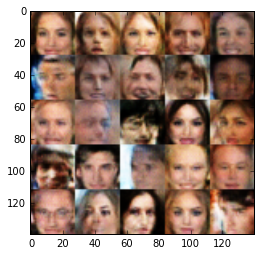

Epoch 1/1 95%... Discriminator Loss: 1.4431... Generator Loss: 0.4885
Epoch 1/1 96%... Discriminator Loss: 1.5477... Generator Loss: 0.4422
Epoch 1/1 97%... Discriminator Loss: 1.2962... Generator Loss: 0.8012
Epoch 1/1 97%... Discriminator Loss: 1.2219... Generator Loss: 0.7056
Epoch 1/1 98%... Discriminator Loss: 1.7390... Generator Loss: 0.3075


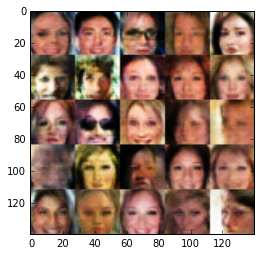

Epoch 1/1 99%... Discriminator Loss: 1.3937... Generator Loss: 0.5700
Epoch 1/1 99%... Discriminator Loss: 1.4487... Generator Loss: 0.5094
Epoch 1/1 100%... Discriminator Loss: 1.4590... Generator Loss: 0.4849


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.